# PHYS 411 - Homework 6
Due Tuesday October 18, 2022 at 9:30.
**Note: This is a much longer (and more difficult) homework than normal. You have two weeks to work on it, but if you leave this to the last minute, you *will* run out of time. Due to the extended deadline, I will not be granting extensions for this problem set. It will also be worth twice as many points as other homeworks.**

This homework will also have a slightly different grading modality. You are allowed to turn it in at any point before the day that it is due, and I will correct it, and you have the option to resubmit anything that is wrong or incomplete.

You can use these buttons below to launch this Jupyter notebook in either [binder](https://mybinder.org/) or [Colab](https://colab.research.google.com/).

[![Open in Binder](https://mybinder.org/badge_logo.svg)](http://beta.mybinder.org/v2/gh/mgrau/phys411/main?urlpath=%2Ftree/Homework%206.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mgrau/phys411/blob/main/Homework%206.ipynb)

When you are finished with your work, please either print to a PDF file and submit via canvas, or submit the raw Jupyter notebook file. For full credit please be sure to clearly explain what you are doing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Problem 1 - Atom core charge distribution
Below I have written a function `R(r, n, l, Z)`, which calculates the electron radial wavefunction for hydrogen-like ions (H, He$^+$, Li$^{2+}$, etc). Consider potassium, which has atomic number $Z=19$.

1. What is the configuration of the ground state of potassium? Write out the full configuration, without abbreviation.
2. There should be five fully filled sub-shells. What are they?
3. Consider each sub-shell. Assume that the innermost subshell sees the full nuclear charge (19e+), but that nuclear charge each successive shell is sees is screened by the inner sib-shells. For example, the next subshell should see an effective nuclear charge of $Z_\text{eff}=17$, and so on until the outmost valence electron sees an effective charge of $Z_\text{eff} =1$. What is the effective nuclear charge that each sub-shell sees?
4. Assume that the electrons in each sub-shell each see the same effective nuclear charge. In a single figure plot the five different electron radial wavefunctions (plot $r R$) corresponding to each sub-shell (remember to change $Z$ for each of them!). For full credit, label your axes (with units) as well as each radial wavefunction. *Hint: use an x-range of $0 a_0$ to $5 a_0$*.
5. Create an effective inner-shells electron charge distribution by summing the square of the electron radial wavefunctions for each of the five inner sub-shells. Remember to multiply each term by the number of electrons in each subshell ($2\times(2l+1)$ ), and to multiply by $r^2$. Plot the inner-shells electron charge distribution.
$$
R_\text{core} = \sqrt{\sum_{n,l} 2(2l+1) \times R^{Z_\text{eff}}_{n,l}(r)^2}
$$
6. What is the effective size of this inner-shells? That is, what is the expectation value $\left<r\right>$ of this charge distribution? Remember, you will need to normalize $R_\text{core}$.

In [2]:
from math import factorial
import scipy.special
def R(r, n=1, l=0, Z=1):
    rho = 2*Z*r/n
    A = (-1)**(n+l+1) * np.sqrt((2*Z/n)**3*factorial(n-l-1)/(2*n*factorial(n+l)))
    L = scipy.special.genlaguerre(n-l-1, 2*l+1)
    return A * rho**l * np.exp(-rho/2) * L(rho)

# Problem 2 - Quantum Defects

## Introduction
In this problem we are going to modify the Coulomb potential to have an effective short range interaction with an unshielded potassium nucleus ($Z=19$), and a long range interaction with a singly-charged K$^+$ atom,
$$
V(r) =\left\{\begin{matrix}-\frac{e^2}{4 \pi \epsilon_0 r} & r > r_\text{core} \\
-\frac{Z e^2}{4 \pi \epsilon_0 r} & r < r_\text{core} \\
\end{matrix}\right.
$$
To do this we will need to be able to solve the radial Schrödinger equation for arbitrary central potentials. I have written several functions that will help with this process. They are not necessarily the most efficient way to solve this problem, but they are the simplest and easiest to under stand. An overview of what the functions are, as well as an example for hydrogen follows:

- `solve_radial(V, E, l, r)`: This function solves the radial Schrödinger for a given potential function `V(r)` and energy `E` and orbital angular momentum quantum number `l` by numerically integrating the differential equation from large values of $r$ down to $r=0$. You should not need to call this function directly.
- `find_energy(V, l, minE, maxE)`: This function finds an eigenenergy of the potential function `V(r)` and orbital angular momentum quantum number `l` by searching between the energies `minE` and `maxE`. It does this via the "shooting" method, where it looks for solutions to the differential equation with the initial condition of 0 at large $r$, and also end up with 0 when integrating down to $r=0$ (satisfying the boundary conditions).
- `find_state(V, l, E, dE)`: This function looks for an eigenstate to the potential function `V(r)` by looking for solutions with energy in the neighborhood of `E` $\pm$ `dE`. It returns the wavefunction but also the energy.
- `find_states(V, l, trial_energies, n=10)`: This does a brute force through all the energies in `trial_energies` looking for eigenenergies of the potential function `V(r)` with orbital angular momentum quantum number `l`. By default it looks for the first `n=10`. This function tends to take a long time (on my computer it takes more than 1 minute).
- `R_calc(r, V, l, energy)`: This is the numerical equivalent to the analytic function `R(r, n=1, l=0, Z=1)` defined above for hydrogen. It is the numerical radial wavefunction, evaluated at `r`, of the potential `V(r)` and orbital angular momentum quantum number `l` and with energy `energy`. Note, it is defined in terms of energy, and not the principal quantum number $n$.

All numerical quantites are in atomic units (lengths are in $a_0$, energies are in hartrees).

In [3]:
from scipy.integrate import solve_ivp, trapezoid
from scipy.optimize import bisect
from scipy.interpolate import interp1d
from scipy.signal import argrelmin

def solve_radial(V, E, l, r, normalize=False):
    def du(r, u):
        return np.array([u[1], (l*(l+1)/r**2 + 2*(V(r) - E)) * u[0]])

    sol = solve_ivp(du, t_span=[r[-1], r[0]], t_eval=r[::-1], y0=[0, -1e-6], method='DOP853', rtol=1e-9)
    u = sol.y[0][::-1]
    if normalize:
        u /= np.max(u)
        u /= np.sqrt(trapezoid(u**2, r))
    return u

def find_energy(V, l, minE, maxE, r=None):
    if r is None:
        r = np.logspace(-6, 2.5, 1000)
    def shoot(E, V, l, r):
        u = solve_radial(V, E, l, r) 
        u0 = u[0] + (u[1]-u[0])*(0.0-r[0])/(r[1]-r[0])
        return u0
    return bisect(shoot, minE, maxE, args=(V, l, r))

def find_state(V, l, E, dE=1e-4):
    r = np.logspace(-9, 2.5, 1000)
    energy = find_energy(V, l=l, minE=E-dE, maxE=E+dE, r=r)
    u = solve_radial(V, energy, l=l, r=r, normalize=True)
    if max(u**2)>1 and len(argrelmin(u**2)[0]) > 0:
        r_min_index = argrelmin(u**2)[0][0]
        r = np.concatenate(([0],r[r_min_index:]))
        u = np.concatenate(([0],u[r_min_index:]))
    u /= np.sqrt(trapezoid(u**2, r))
    return interp1d(r, u, fill_value='extrapolate'), energy
    
def find_states(V, l, trial_energies, n=10):
    energies = []
    for energy1, energy2 in zip(trial_energies[:-1],trial_energies[1:]):
        try:
            result = find_energy(V, l, energy1, energy2)
            print(f'found energy: {result} hartrees')
            energies.append(result)
        except:
            pass
        if len(energies) >= n:
            break
    return np.array(energies)

def R_calc(r, V, l, energy):
    f, _ = find_state(V, l, energy)
    return np.divide(f(r), r, out=np.zeros(np.size(r)), where=r!=0)

Here is an example of how to use these functions to numerically solve for the radial wavefunctions to hydrogen. I define a potential function `V(r)` which is the Coulomb potential (in atomic units). I then search through 1000 trial energies, ranging from -0.55 hartrees to 0 hartrees looking for the first 10 eigenenergies (saved as `H_calc`. I then exactly calculate the first 10 energies using the Rydberg formula (`H_true`). Using this I can find the error of the calculation `H_error = H_calc - H_true`. I provide some example wavefunction figures as well.

In [4]:
def V(r):
    return -1/r

trial_energies = np.linspace(-0.55,0,1000)
H_calc = find_states(V, 0, trial_energies=trial_energies, n=10)

n = np.arange(1,11)
H_true = -0.5 / n**2

H_error = H_calc - H_true

found energy: -0.5000000000265692 hartrees
found energy: -0.12499999997921077 hartrees
found energy: -0.05555555555303848 hartrees
found energy: -0.031249999999160952 hartrees
found energy: -0.01999999999942201 hartrees
found energy: -0.013888888887490496 hartrees
found energy: -0.010204081631939602 hartrees
found energy: -0.007812499804692582 hartrees
found energy: -0.006172821123816758 hartrees
found energy: -0.00500063901278639 hartrees


In [5]:
# !pip install tabulate
import tabulate
tabulate.tabulate(zip(n, H_true, H_calc, H_error), 
                  headers=['n', 'True Energy (hartree)', 'Calculate Energy (hartree)', 'Error (hartree)'], 
                  tablefmt='html')

n,True Energy (hartree),Calculate Energy (hartree),Error (hartree)
1,-0.5,-0.5,-2.65692e-11
2,-0.125,-0.125,2.07892e-11
3,-0.0555556,-0.0555556,2.51707e-12
4,-0.03125,-0.03125,8.39048e-13
5,-0.02,-0.02,5.77989e-13
6,-0.0138889,-0.0138889,1.39839e-12
7,-0.0102041,-0.0102041,7.13459e-13
8,-0.0078125,-0.0078125,1.95307e-10
9,-0.00617284,-0.00617282,1.83824e-08
10,-0.005,-0.00500064,-6.39013e-07


Text(0, 0.5, '$r R$')

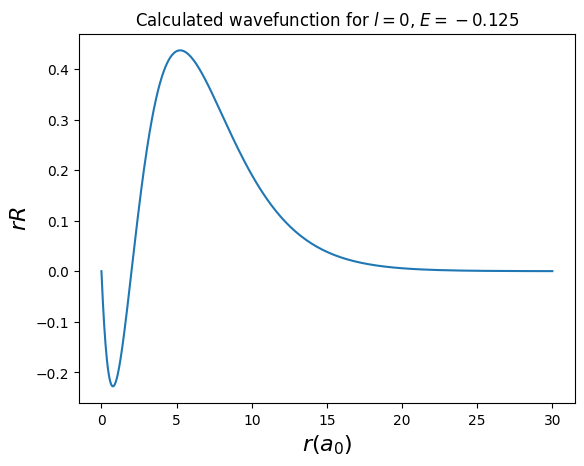

In [6]:
r = np.linspace(0, 30, 1000)
plt.plot(r, r*R_calc(r, V, l=0, energy=-0.125))
plt.title('Calculated wavefunction for $l=0$, $E=-0.125$')
plt.xlabel('$r (a_0)$', fontsize=16)
plt.ylabel('$r R$', fontsize=16)

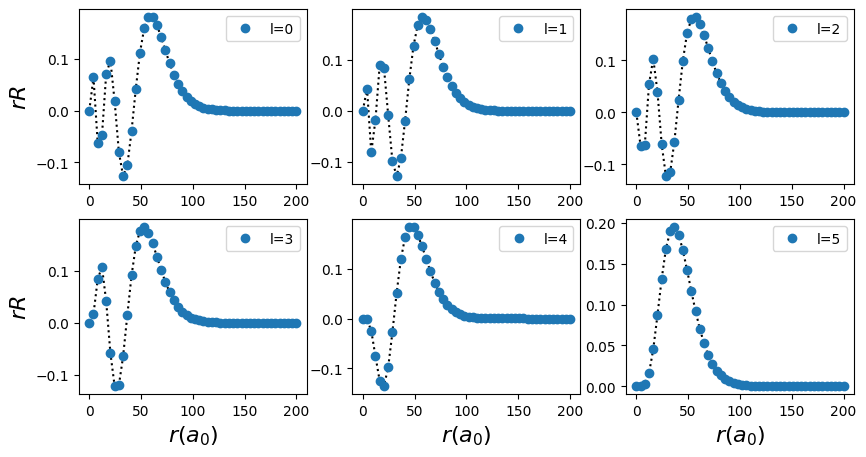

In [7]:
r = np.linspace(0, 200)
plt.figure(figsize=(10,5))
for l in range(6):
    plt.subplot(2,3,l+1)
    plt.plot(r, r*R(r, n=6, l=l), 'k:')
    plt.plot(r, r*R_calc(r, V, l=l, energy=H_calc[6-1]), 'o', label=f'l={l}')
    if l>2:
        plt.xlabel('$r (a_0)$', fontsize=16)
    if not l%3:
        plt.ylabel('$r R$', fontsize=16)
    plt.legend()

## Problems:
1. write a function `V_K(r)` to describe the effective potential of the valence electron in potassium. The potential should be `-1/r` for long range (`r > r_core`) and `-19/r` for short range. Why is this a reasonable potential for potassium? What is a good value to use for `r_core`? What are the potential shortcomings of this approximatin?
2. Use `find_states` to calculate the first 10 energies of this effective potential `V_K(r)` for $l=$ s, p, d, and f (that is `l=0,1,2,3,4`). You should find the energies of 40 states in total. Unlike in hydrogen, the degeneracy between different $l$ states has been broken. Explain why.
3. Create a figure comparing the calculated energy of your states to the measured energy of potassium, using the data from Homework 4 (I've included it below in the variable `K_data`). *Note: this data is in units of eV, you will need to convert to hartrees to compare!*
4. For each of the four different $l$ series, plot $1/\sqrt{-E}$ against $n$ (note that $n$ starts at 4 for $l$=s, p, and f and that $n$ begins at 3 for $l$=3). If your data follows the Rydberg series you should find a straight line. Fit this to extract the quantum defect $\delta_l$ for each value of $l$. Compare with the experimental values from Homework 4.
5. Plot the radial wavefunction for potassium `r R_calc` for the first three states in each $nl$ series. Compare to the hydrogen wavefunction $r R_{nl}$. Show that at long range ($r > r_\text{core}$) that the wavefunctions are the same, other than a slight phase shift that is proportional to the quantum defect. *Note: when comparing with hydrogen, you will want to subtract off the quantum defect from the the principal quantum number, rounded off to the nearest integer. So to compare with the $4s$ state in potassium, with a quantum defect of e.g., $\delta_s = 2.22$, subtract off 2 and then compare with the $2s$ state of hydrogen*.
6. Plot the lowest energy radial wavefunction for potassium `r R_calc` for $l=$ s, p, d, and f, focusing the region where $r < 5 a_0$. Use this to explain the phase shift, and hence the quantum defect, that you see measure.

**Bonus: you probably are not able to exactly replicate the measured values for energies and the quantum defect of potassium. Can you vary the parameters of your potential function `V_K(r)` to more closely match the experimental data?**

In [8]:
def V_K(r):
    if r>r_core:
        return -1/r
    else:
        return -19/r

In [9]:
K_data = {
    "s": [
        -4.34066373,
        -1.7337036300000004,
        -0.9372094300000002,
        -0.5871352300000003,
        -0.40225893000000035,
        -0.2927840900000005,
        -0.22262446000000047,
        -0.17497323999999992,
        -0.14113558000000026,
        -0.11624444999999994,
    ],
    "p": [
        -2.7259357760333334,
        -1.2765323300000002,
        -0.7445147300000001,
        -0.48811472999999994,
        -0.3447500633333336,
        -0.25645662999999974,
        -0.19822649666666692,
        -0.15780243000000027,
        -0.12859666333333397,
        -0.10680996333333326,
    ],
    "d": [
        -1.6705892500000004,
        -0.9438060500000005,
        -0.59814547,
        -0.41085977000000007,
        -0.2989833940000004,
        -0.22709450600000025,
        -0.17825562000000073,
        -0.14359849199999974,
        -0.11813159400000028,
        -0.09887615400000005,
    ],
    "f": [
        -0.8532547300000002,
        -0.54591273,
        -0.37897573000000007,
        -0.27834673,
        -0.21305572999999978,
        -0.16830773000000043,
        -0.1363077300000004,
        -0.11263372999999977,
        -0.09465473000000024,
        -0.08064573000000053,
    ],
}